In [83]:
import os

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from trainer_dif import TrainerMultiple
from torch.utils.data import DataLoader

import torch
from tqdm import tqdm

import numpy as np
from pathlib import Path
from utils import check_existence
import pickle

import data_dif as data
from data_dif import load_pil_image
from pprint import pprint
from itertools import product
import skimage
import os
from tempfile import TemporaryDirectory
import scipy

In [98]:
def test(image_dir, fingerprint_dir) -> (float, float):
    images_dir = Path(image_dir)
    check_dir = Path(fingerprint_dir)

    check_existence(check_dir, False)
    check_existence(images_dir, False)

    with open(check_dir / "train_hypers.pt", 'rb') as pickle_file:
        hyper_pars = pickle.load(pickle_file)

    hyper_pars['Device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyper_pars['Batch Size'] = 1

    print(f'Working on {images_dir.stem}')

    real_path_list = [list((images_dir / "0_real").glob('*.' + x)) for x in ['jpg', 'jpeg', 'png']]
    real_path_list = [ele for ele in real_path_list if ele != []][0]

    fake_path_list = [list((images_dir / "1_fake").glob('*.' + x)) for x in ['jpg', 'jpeg', 'png']]
    fake_path_list = [ele for ele in fake_path_list if ele != []][0]

    test_set = data.PRNUData(real_path_list, fake_path_list, hyper_pars, demand_equal=False,
                             train_mode=False)

    trainer = TrainerMultiple(hyper_pars)
    trainer.load_stats(check_dir / f"chk_0.pt")

    trainer.test_model(test_set.get_loader())
    acc_f, acc_r = trainer.calc_accuracy(print_res=False)
    mu_real, mu_fake = trainer.mu_real, trainer.mu_fake

    return acc_f, acc_r, mu_real, mu_fake

In [99]:
models = ['dalle_2', 'dalle_mini', 'glide', 'mj', 'sd14', 'sd21']

checks = []
datas = []

for model in models:
    checks.append(f'checks/{model}')
    datas.append(f'data/{model}')

# Models without data modifications

In [100]:
results = []
for model, data_dir, check in zip(models, datas, checks):
    acc_r, acc_f, mu_real, mu_fake = test(data_dir, check)
    results.append({'model': model, 'mods': 'none', 'R': acc_r, 'F': acc_f, 'T': (acc_r + acc_f) / 2, 'mu_R': mu_real, 'mu_F': mu_fake})
    print(f'{model}: R{100 * acc_r:.1f}, F{100 * acc_f:.1f}, T{50 * (acc_r + acc_f):.1f}, muR{mu_real:.4f}, muF{mu_fake:.4f}')

Working on dalle_2


Testing Model: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


dalle_2: R60.0, F90.0, T75.0, muR0.0015, muF-0.0075
Working on dalle_mini


Testing Model: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


dalle_mini: R90.0, F100.0, T95.0, muR0.0027, muF-0.0105
Working on glide


Testing Model: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


glide: R100.0, F70.0, T85.0, muR0.0042, muF0.0156
Working on mj


Testing Model: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


mj: R100.0, F100.0, T100.0, muR0.0007, muF-0.0132
Working on sd14


Testing Model: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


sd14: R100.0, F100.0, T100.0, muR-0.0010, muF0.0131
Working on sd21


Testing Model: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

sd21: R90.0, F90.0, T90.0, muR-0.0018, muF0.0080


# Data modification: Resizing

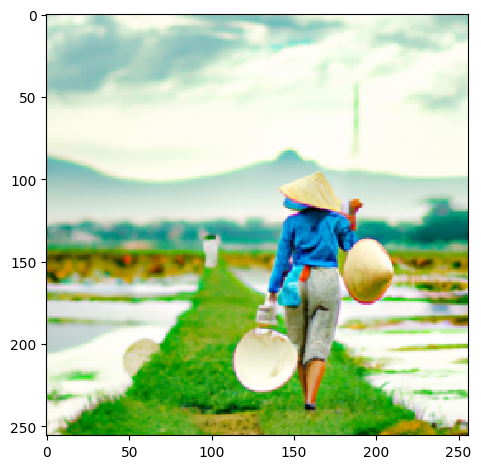

In [101]:
im = skimage.io.imread(Path('data/dalle_2/1_fake/img_26962.png'))
res = skimage.transform.rescale(im, scale=0.5, channel_axis=-1)
skimage.io.imshow(res);

In [102]:
rescale_factors = [0.5, 2]
alias = [True]
for scale, anti_alias in product(rescale_factors, alias):
    for model in models:
        for subdir in ['0_real', '1_fake']:
            data_dir = Path(f'data/{model}/{subdir}')
            save_to = Path(f'data/{model}_rescale/{subdir}')
            
            os.makedirs(save_to, exist_ok=True)
            
            for image_file in Path(data_dir).rglob('*.png'):
                im = skimage.io.imread(image_file)
                tr_im = skimage.transform.rescale(im, scale=scale, channel_axis=-1)
                skimage.io.imsave(Path(save_to) / f'{image_file.stem}_scale{scale}.png', (tr_im * 255).astype(np.uint8))

In [103]:
datas = []

for model in models:
    datas.append(f'data/{model}_rescale')

In [104]:
for model, data_dir, check in zip(models, datas, checks):
    acc_r, acc_f, mu_real, mu_fake = test(data_dir, check)
    results.append({'model': model, 'mods': 'rescale', 'R': acc_r, 'F': acc_f, 'T': (acc_r + acc_f) / 2, 'mu_R': mu_real, 'mu_F': mu_fake})
    print(f'{model}: R{100 * acc_r:.1f}, F{100 * acc_f:.1f}, T{50 * (acc_r + acc_f):.1f}, muR{mu_real:.4f}, muF{mu_fake:.4f}')

Working on dalle_2_rescale


Testing Model: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


dalle_2: R50.0, F90.0, T70.0, muR0.0015, muF-0.0075
Working on dalle_mini_rescale


Testing Model: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


dalle_mini: R0.0, F100.0, T50.0, muR0.0027, muF-0.0105
Working on glide_rescale


Testing Model: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


glide: R50.0, F50.0, T50.0, muR0.0042, muF0.0156
Working on mj_rescale


Testing Model: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


mj: R0.0, F100.0, T50.0, muR0.0007, muF-0.0132
Working on sd14_rescale


Testing Model: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


sd14: R0.0, F100.0, T50.0, muR-0.0010, muF0.0131
Working on sd21_rescale


Testing Model: 100%|██████████| 40/40 [00:42<00:00,  1.06s/it]

sd21: R20.0, F90.0, T55.0, muR-0.0018, muF0.0080


# Data modification: Rotation

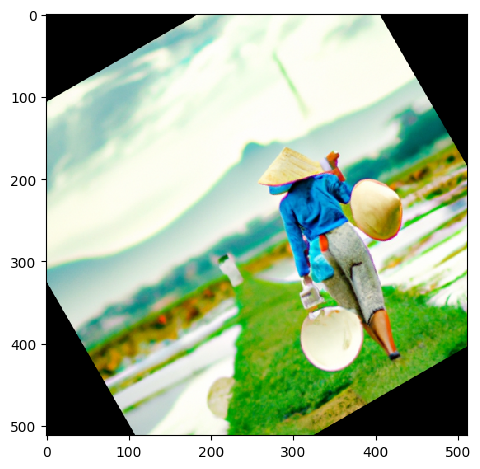

In [105]:
im = skimage.io.imread(Path('data/dalle_2/1_fake/img_26962.png'))
res = skimage.transform.rotate(im, angle=30)
skimage.io.imshow(res);

In [106]:
rotate_degrees = [30, -30]
for rot in rotate_degrees:
    for model in models:
        for subdir in ['0_real', '1_fake']:
            data_dir = Path(f'data/{model}/{subdir}')
            save_to = Path(f'data/{model}_rotate/{subdir}')
            
            os.makedirs(save_to, exist_ok=True)
            
            for image_file in Path(data_dir).rglob('*.png'):
                im = skimage.io.imread(image_file)
                tr_im = skimage.transform.rotate(im, angle=rot)
                skimage.io.imsave(Path(save_to) / f'{image_file.stem}_angle{rot}.png', (tr_im * 255).astype(np.uint8))

In [107]:
datas = []

for model in models:
    datas.append(f'data/{model}_rotate')

In [108]:
for model, data_dir, check in zip(models, datas, checks):
    acc_r, acc_f, mu_real, mu_fake = test(data_dir, check)
    results.append({'model': model, 'mods': 'rotate', 'R': acc_r, 'F': acc_f, 'T': (acc_r + acc_f) / 2, 'mu_R': mu_real, 'mu_F': mu_fake})
    print(f'{model}: R{100 * acc_r:.1f}, F{100 * acc_f:.1f}, T{50 * (acc_r + acc_f):.1f}, muR{mu_real:.4f}, muF{mu_fake:.4f}')

Working on dalle_2_rotate


Testing Model: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


dalle_2: R55.0, F85.0, T70.0, muR0.0015, muF-0.0075
Working on dalle_mini_rotate


Testing Model: 100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


dalle_mini: R5.0, F100.0, T52.5, muR0.0027, muF-0.0105
Working on glide_rotate


Testing Model: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


glide: R25.0, F70.0, T47.5, muR0.0042, muF0.0156
Working on mj_rotate


Testing Model: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


mj: R0.0, F100.0, T50.0, muR0.0007, muF-0.0132
Working on sd14_rotate


Testing Model: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


sd14: R0.0, F100.0, T50.0, muR-0.0010, muF0.0131
Working on sd21_rotate


Testing Model: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

sd21: R0.0, F95.0, T47.5, muR-0.0018, muF0.0080


# Data modification: JPEG compression

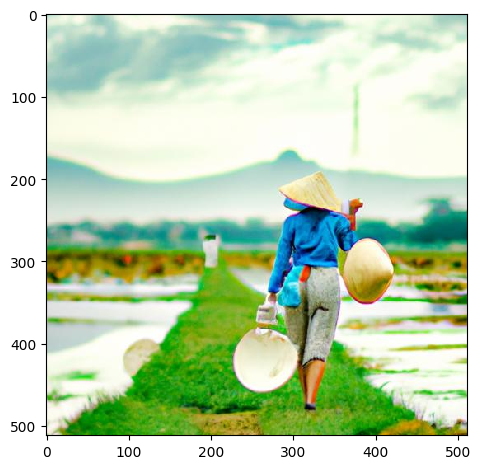

In [109]:
from tempfile import TemporaryDirectory

im = skimage.io.imread(Path('data/dalle_2/1_fake/img_26962.png'))
with TemporaryDirectory() as t:
    skimage.io.imsave(Path(t) / 'test.jpeg', im)
    res = skimage.io.imread(Path(t) / 'test.jpeg')
    skimage.io.imshow(res)

In [110]:
for model in models:
    for subdir in ['0_real', '1_fake']:
        data_dir = Path(f'data/{model}/{subdir}')
        save_to = Path(f'data/{model}_jpeg/{subdir}')
        
        os.makedirs(save_to, exist_ok=True)
        
        for image_file in Path(data_dir).rglob('*.png'):
            im = skimage.io.imread(image_file)
            if im.shape[-1] == 4:
                im = (skimage.color.rgba2rgb(im) * 255).astype(np.uint8)
            skimage.io.imsave(Path(save_to) / f'{image_file.stem}.jpeg', im)

In [111]:
datas = []

for model in models:
    datas.append(f'data/{model}_jpeg')

In [112]:
for model, data_dir, check in zip(models, datas, checks):
    acc_r, acc_f, mu_real, mu_fake = test(data_dir, check)
    results.append({'model': model, 'mods': 'jpeg', 'R': acc_r, 'F': acc_f, 'T': (acc_r + acc_f) / 2, 'mu_R': mu_real, 'mu_F': mu_fake})
    print(f'{model}: R{100 * acc_r:.1f}, F{100 * acc_f:.1f}, T{50 * (acc_r + acc_f):.1f}, muR{mu_real:.4f}, muF{mu_fake:.4f}')

Working on dalle_2_jpeg


Testing Model: 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


dalle_2: R30.0, F80.0, T55.0, muR0.0015, muF-0.0075
Working on dalle_mini_jpeg


Testing Model: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


dalle_mini: R10.0, F100.0, T55.0, muR0.0027, muF-0.0105
Working on glide_jpeg


Testing Model: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


glide: R40.0, F80.0, T60.0, muR0.0042, muF0.0156
Working on mj_jpeg


Testing Model: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


mj: R0.0, F100.0, T50.0, muR0.0007, muF-0.0132
Working on sd14_jpeg


Testing Model: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


sd14: R0.0, F100.0, T50.0, muR-0.0010, muF0.0131
Working on sd21_jpeg


Testing Model: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]

sd21: R0.0, F90.0, T45.0, muR-0.0018, muF0.0080


# Contrast correction

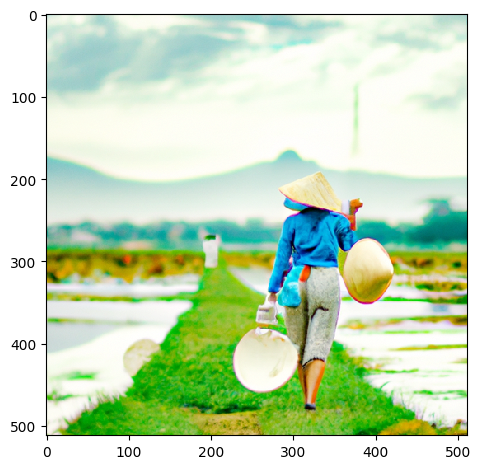

In [113]:
im = skimage.io.imread(Path('data/dalle_2/1_fake/img_26962.png'))
res = skimage.exposure.adjust_log(im, gain=1)
skimage.io.imshow(res);

In [114]:
for model in models:
    for subdir in ['0_real', '1_fake']:
        data_dir = Path(f'data/{model}/{subdir}')
        save_to = Path(f'data/{model}_contrast/{subdir}')
        
        os.makedirs(save_to, exist_ok=True)
        
        for image_file in Path(data_dir).rglob('*.png'):
            im = skimage.io.imread(image_file)
            tr_im = skimage.exposure.adjust_log(im, gain=1)
            skimage.io.imsave(Path(save_to) / f'{image_file.stem}_gain1.png', tr_im)

In [115]:
datas = []

for model in models:
    datas.append(f'data/{model}_contrast')

In [116]:
for model, data_dir, check in zip(models, datas, checks):
    acc_r, acc_f, mu_real, mu_fake = test(data_dir, check)
    results.append({'model': model, 'mods': 'contrast', 'R': acc_r, 'F': acc_f, 'T': (acc_r + acc_f) / 2, 'mu_R': mu_real, 'mu_F': mu_fake})
    print(f'{model}: R{100 * acc_r:.1f}, F{100 * acc_f:.1f}, T{50 * (acc_r + acc_f):.1f}, muR{mu_real:.4f}, muF{mu_fake:.4f}')

Working on dalle_2_contrast


Testing Model: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


dalle_2: R80.0, F90.0, T85.0, muR0.0015, muF-0.0075
Working on dalle_mini_contrast


Testing Model: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


dalle_mini: R90.0, F100.0, T95.0, muR0.0027, muF-0.0105
Working on glide_contrast


Testing Model: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


glide: R100.0, F70.0, T85.0, muR0.0042, muF0.0156
Working on mj_contrast


Testing Model: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


mj: R100.0, F100.0, T100.0, muR0.0007, muF-0.0132
Working on sd14_contrast


Testing Model: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


sd14: R100.0, F100.0, T100.0, muR-0.0010, muF0.0131
Working on sd21_contrast


Testing Model: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

sd21: R90.0, F90.0, T90.0, muR-0.0018, muF0.0080


# Data modification: 1-Pixel shift

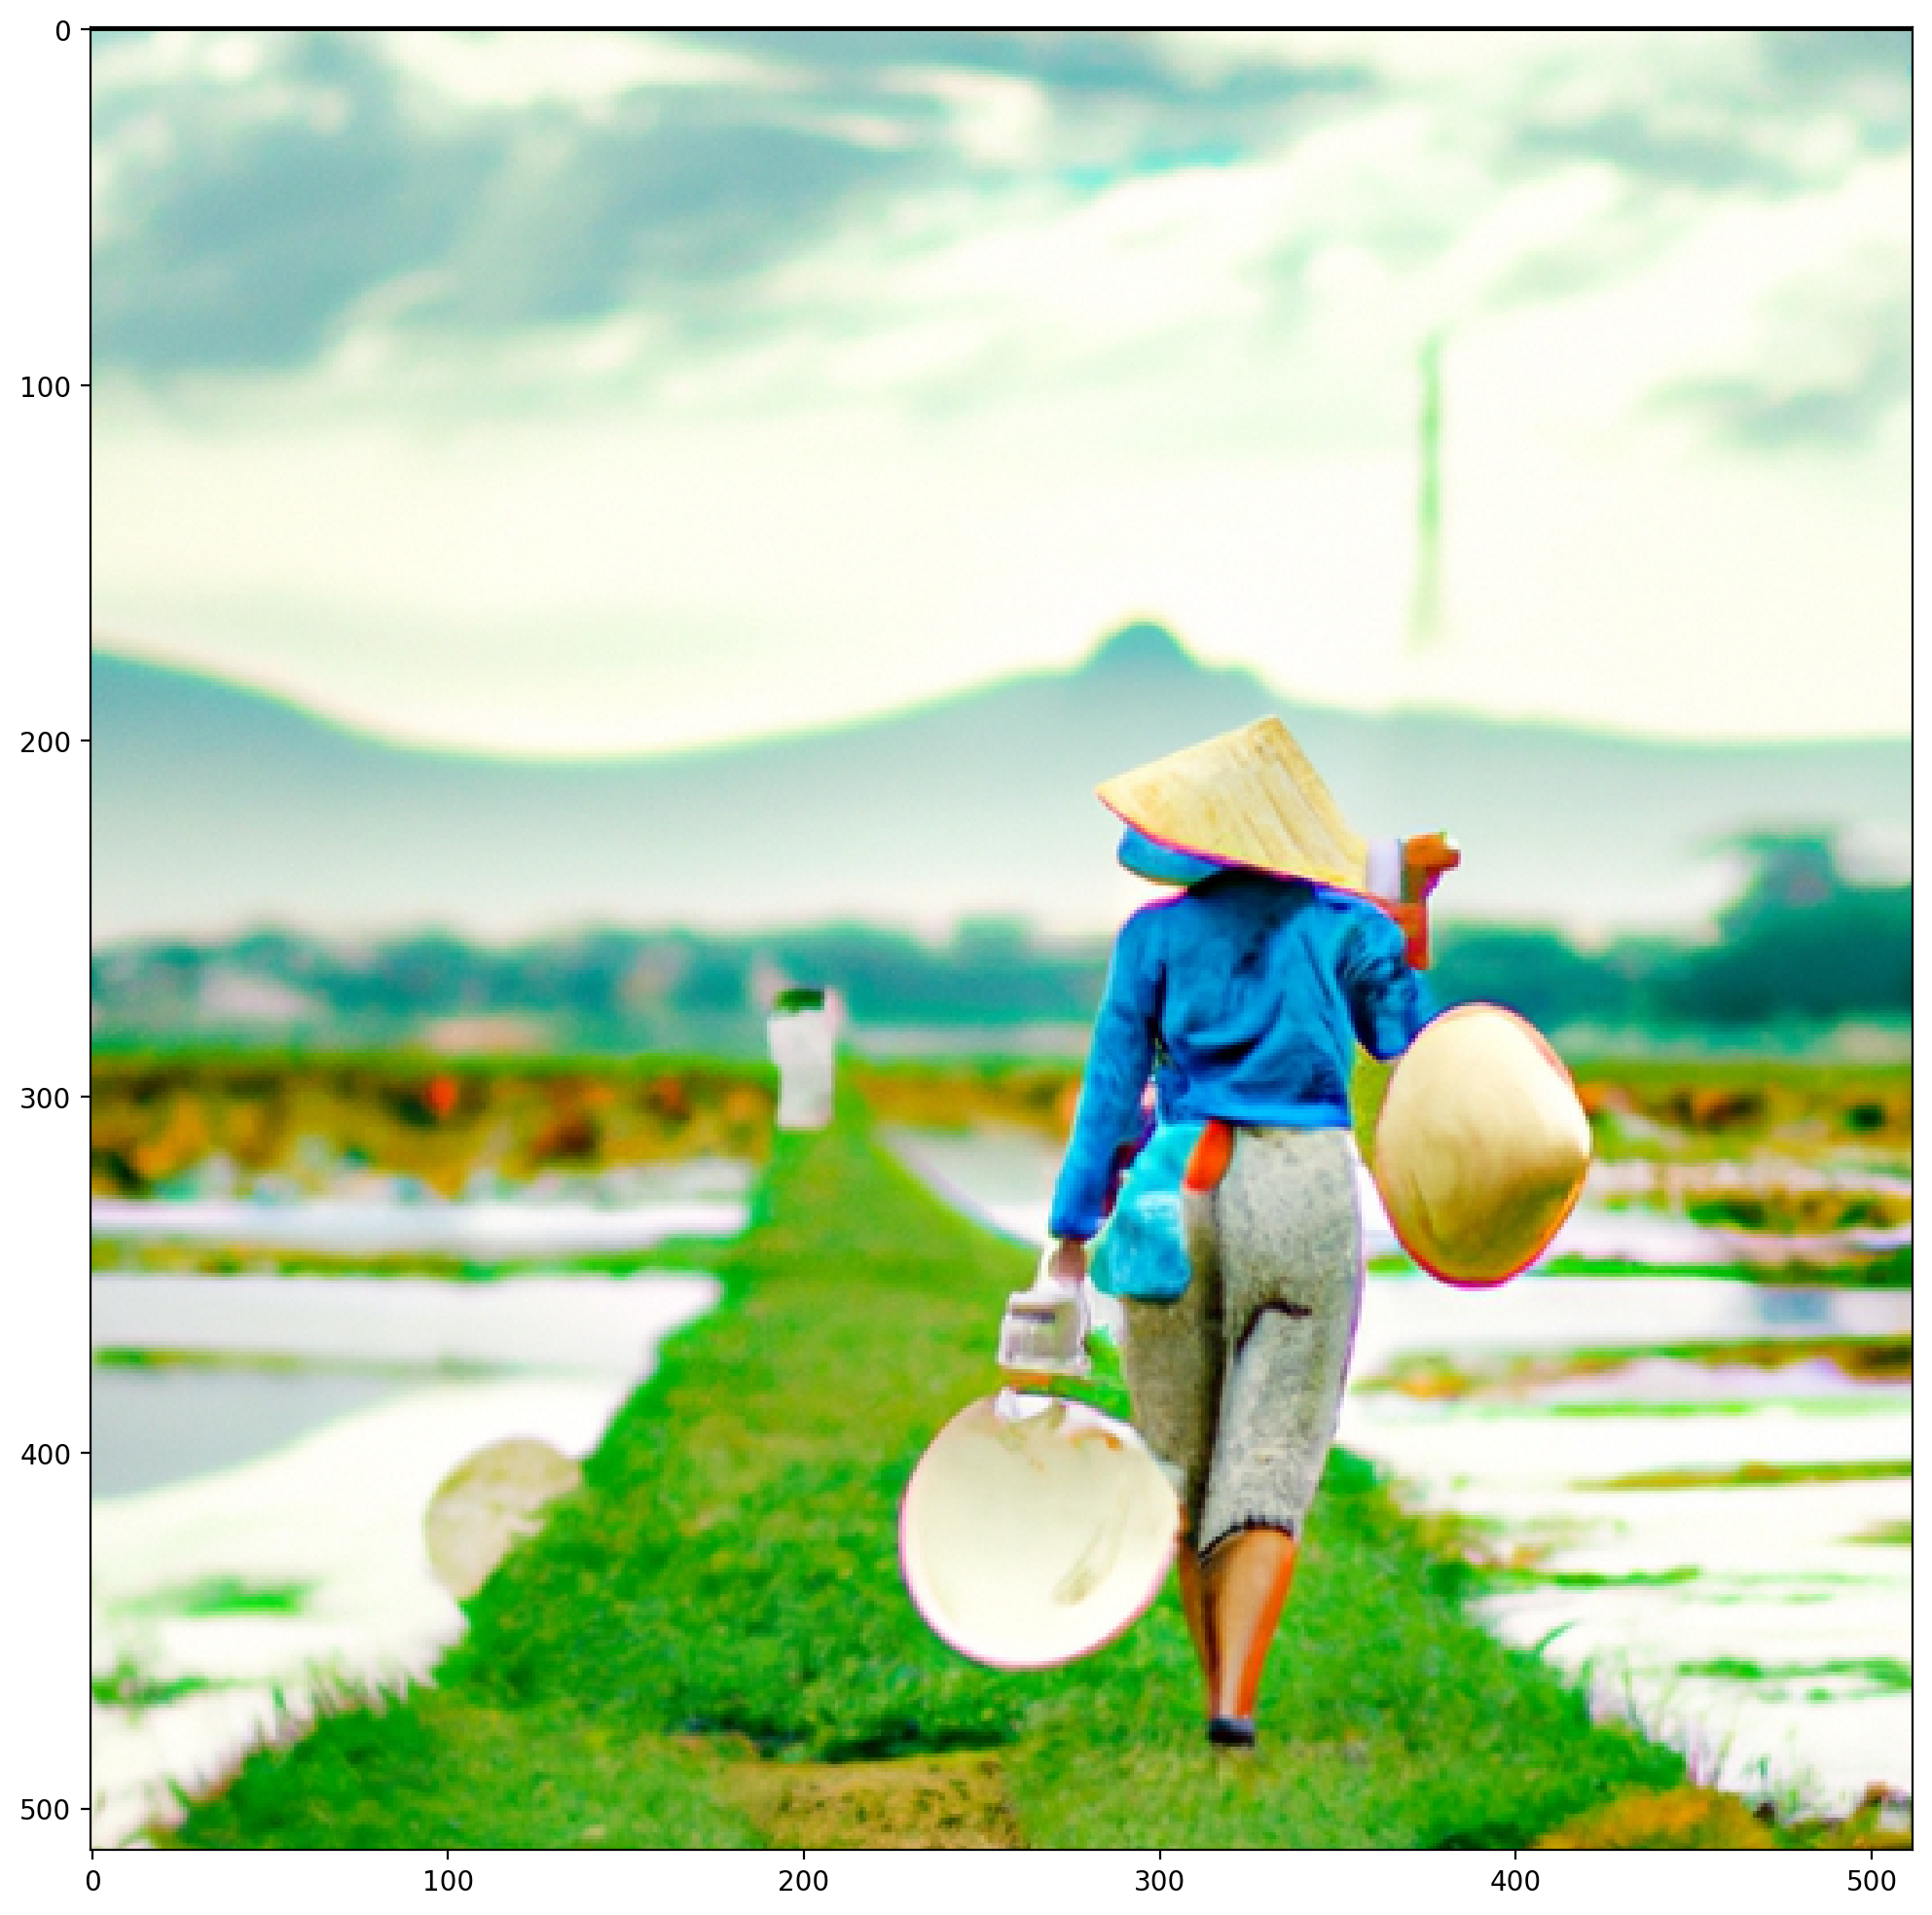

In [137]:
from matplotlib import pyplot as plt
im = skimage.io.imread(Path('data/dalle_2/1_fake/img_26962.png'))
res = scipy.ndimage.shift(im, (1, 0, 0))
plt.figure(figsize=(10, 10), dpi=200)
skimage.io.imshow(res);

In [118]:
for model in models:
    for subdir in ['0_real', '1_fake']:
        data_dir = Path(f'data/{model}/{subdir}')
        save_to = Path(f'data/{model}_shift/{subdir}')
        
        os.makedirs(save_to, exist_ok=True)
        
        for image_file in Path(data_dir).rglob('*.png'):
            im = skimage.io.imread(image_file)
            tr_im = scipy.ndimage.shift(im, (1, 0, 0))
            skimage.io.imsave(Path(save_to) / f'{image_file.stem}.png', tr_im)

In [119]:
datas = []

for model in models:
    datas.append(f'data/{model}_shift')

In [120]:
for model, data_dir, check in zip(models, datas, checks):
    acc_r, acc_f, mu_real, mu_fake = test(data_dir, check)
    results.append({'model': model, 'mods': '1pxshift', 'R': acc_r, 'F': acc_f, 'T': (acc_r + acc_f) / 2, 'mu_R': mu_real, 'mu_F': mu_fake})
    print(f'{model}: R{100 * acc_r:.1f}, F{100 * acc_f:.1f}, T{50 * (acc_r + acc_f):.1f}, muR{mu_real:.4f}, muF{mu_fake:.4f}')

Working on dalle_2_shift


Testing Model: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


dalle_2: R60.0, F90.0, T75.0, muR0.0015, muF-0.0075
Working on dalle_mini_shift


Testing Model: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


dalle_mini: R0.0, F100.0, T50.0, muR0.0027, muF-0.0105
Working on glide_shift


Testing Model: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


glide: R80.0, F70.0, T75.0, muR0.0042, muF0.0156
Working on mj_shift


Testing Model: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


mj: R0.0, F100.0, T50.0, muR0.0007, muF-0.0132
Working on sd14_shift


Testing Model: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


sd14: R0.0, F100.0, T50.0, muR-0.0010, muF0.0131
Working on sd21_shift


Testing Model: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

sd21: R0.0, F100.0, T50.0, muR-0.0018, muF0.0080


# Sanity check: No modifications

In [80]:
for model in models:
    for subdir in ['0_real', '1_fake']:
        data_dir = Path(f'data/{model}/{subdir}')
        save_to = Path(f'data/{model}_nomods/{subdir}')
        
        os.makedirs(save_to, exist_ok=True)
        
        for image_file in Path(data_dir).rglob('*.png'):
            im = skimage.io.imread(image_file)
            skimage.io.imsave(Path(save_to) / f'{image_file.stem}.png', im)

In [81]:
datas = []

for model in models:
    datas.append(f'data/{model}_nomods')

In [82]:
for model, data_dir, check in zip(models, datas, checks):
    acc_r, acc_f, mu_real, mu_fake = test(data_dir, check)
    results.append({'model': model, 'mods': 'sanity', 'R': acc_r, 'F': acc_f, 'T': (acc_r + acc_f) / 2, 'mu_R': mu_real, 'mu_F': mu_fake})
    print(f'{model}: R{100 * acc_r:.1f}, F{100 * acc_f:.1f}, T{50 * (acc_r + acc_f):.1f}, muR{mu_real:.4f}, muF{mu_fake:.4f}')

Working on dalle_2_nomods


Testing Model: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


dalle_2: R60.0, F90.0, T75.0
Working on dalle_mini_nomods


Testing Model: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


dalle_mini: R90.0, F100.0, T95.0
Working on glide_nomods


Testing Model: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


glide: R100.0, F70.0, T85.0
Working on mj_nomods


Testing Model: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


mj: R100.0, F100.0, T100.0
Working on sd14_nomods


Testing Model: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


sd14: R100.0, F100.0, T100.0
Working on sd21_nomods


Testing Model: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

sd21: R90.0, F90.0, T90.0


In [122]:
import pandas as pd

In [123]:
data = pd.DataFrame(results)

In [124]:
data.columns

Index(['model', 'mods', 'R', 'F', 'T', 'mu_R', 'mu_F'], dtype='object')

In [129]:
data.to_html('data.html')

In [131]:
import pdfkit as pdf

In [133]:
pdf.from_file('data.html', 'data.pdf')

True